## Importar las bibliotecas necesarias

In [88]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsmodels.tools.eval_measures import mse, rmse, meanabs
import seaborn as sns
from scipy import stats
import warnings

In [89]:
warnings.filterwarnings("ignore")

## Carga y preparación de datos

In [90]:
df = pd.read_csv("/Users/marcosherediapimienta/Library/Mobile Documents/com~apple~CloudDocs/Documents/Máster de Matemàtiques per els Instruments Financers/TFM/Time_Series/archive/Top10-2021-2024-1d.csv")

df_selected = df[['Timestamp', 'BTCUSDT']]
df_selected = df_selected.rename(columns={'Timestamp':'ds', 'BTCUSDT': 'y'})
df_selected = df_selected.dropna()

df_selected["unique_id"] = "1"
df_selected.columns = ["ds", "y", "unique_id"]

df_selected["ds"] = pd.to_datetime(df_selected["ds"])

## Análisis de autocorrelación y descomposición estacional

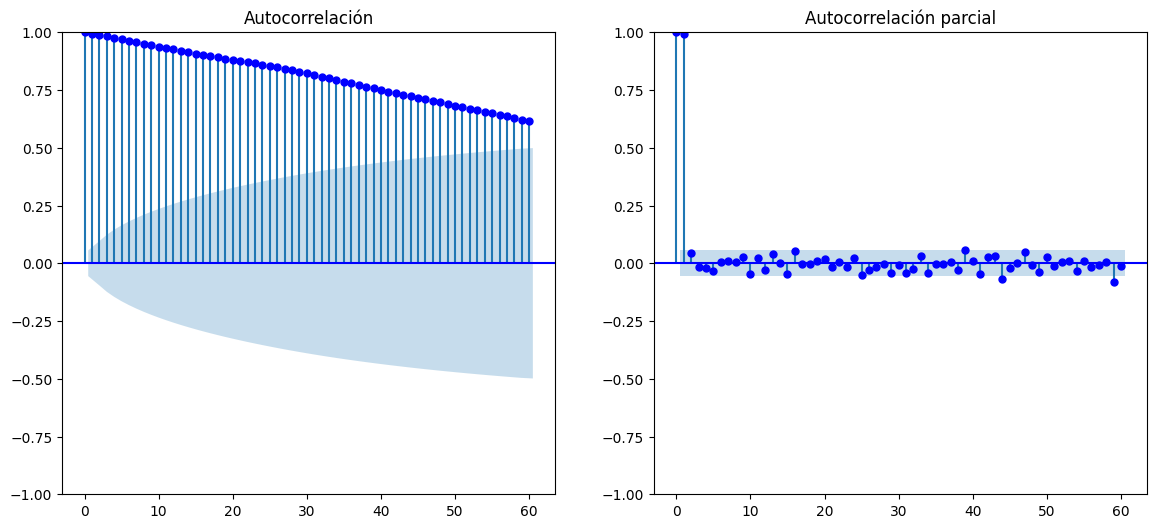

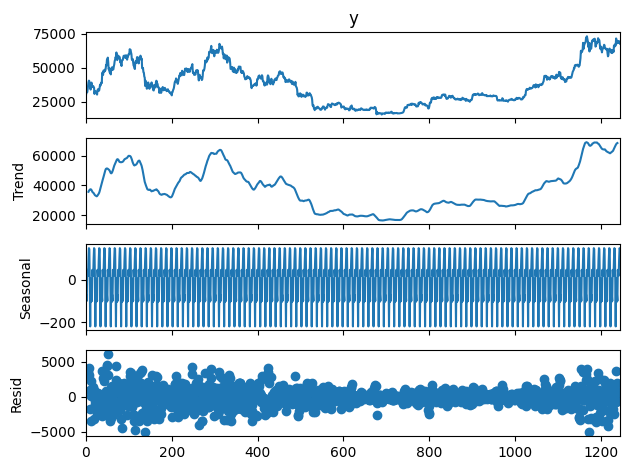

In [91]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
plot_acf(df_selected["y"], lags=60, ax=axs[0], color="blue")
axs[0].set_title("Autocorrelación")
plot_pacf(df_selected["y"], lags=60, ax=axs[1], color="blue")
axs[1].set_title('Autocorrelación parcial')

decomposition = seasonal_decompose(df_selected['y'], model='additive', period=12)
decomposition.plot()
plt.show()

## Separación de los datos en conjuntos de entrenamiento y prueba

In [92]:
Y_train_df = df_selected[df_selected.ds <= '2024-05-01']
Y_test_df = df_selected[df_selected.ds > '2024-05-01']

## Configuración y ajuste del modelo AutoARIMA

In [93]:
season_length = 12
horizon = len(Y_test_df)
models = [AutoARIMA(season_length=season_length)]

sf = StatsForecast(df=Y_train_df,
                   models=models,
                   freq='D',
                   n_jobs=-1)

sf.fit()

StatsForecast(models=[AutoARIMA])

## Análisis del modelo ajustado y sus residuos

dict_keys(['coef', 'sigma2', 'var_coef', 'mask', 'loglik', 'aic', 'arma', 'residuals', 'code', 'n_cond', 'nobs', 'model', 'bic', 'aicc', 'ic', 'xreg', 'x', 'lambda'])
(1, 0, 2, 0, 12, 1, 0)


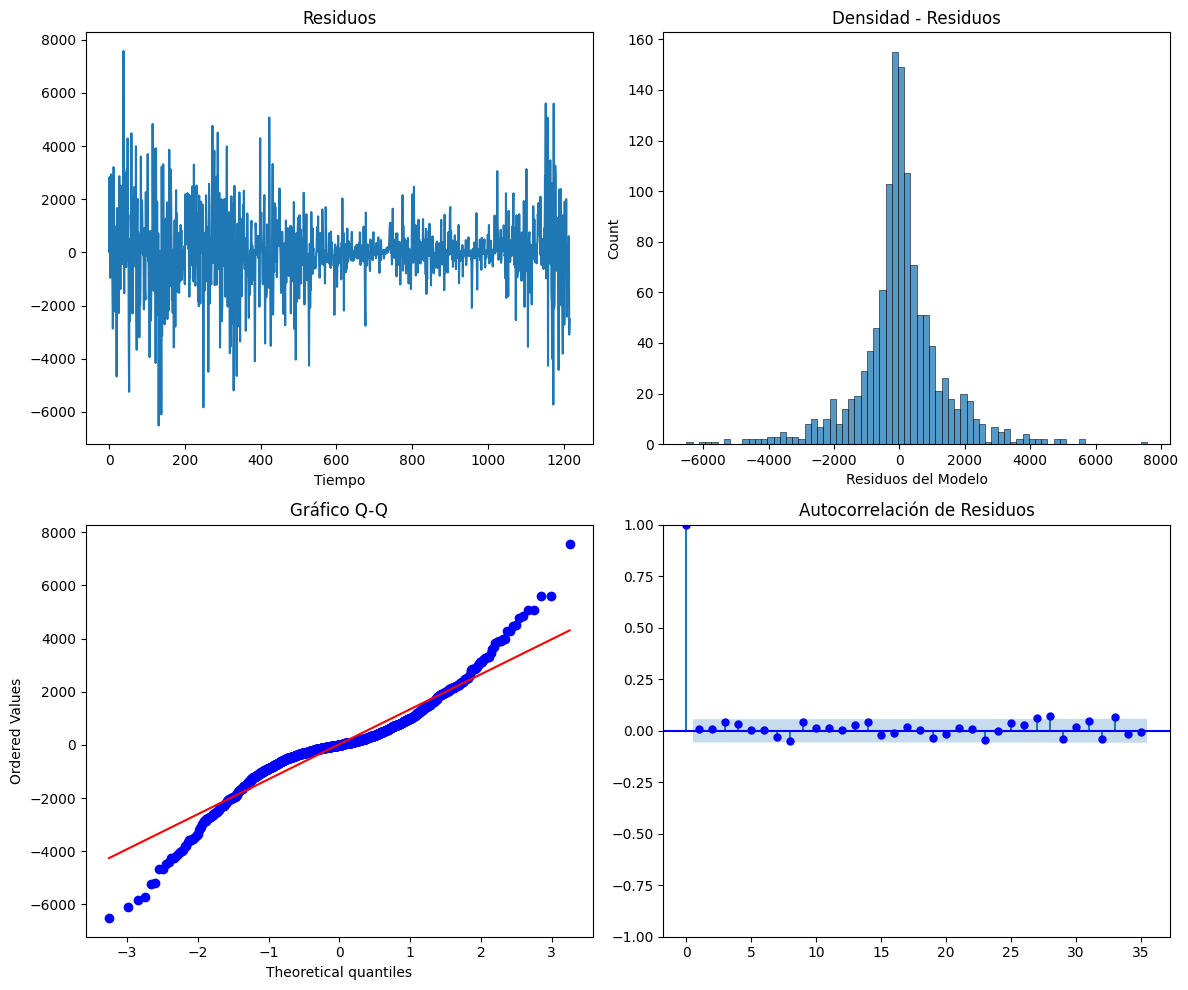

In [94]:
result = sf.fitted_[0,0].model_
print(result.keys())
print(result['arma'])

residual = pd.DataFrame(result.get("residuals"), columns=["Residuos del Modelo"])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
residual['Residuos del Modelo'].plot(ax=axs[0, 0])
axs[0, 0].set_title("Residuos")
axs[0, 0].set_xlabel('Tiempo')

sns.histplot(residual['Residuos del Modelo'], ax=axs[0, 1])
axs[0, 1].set_title("Densidad - Residuos")

stats.probplot(residual['Residuos del Modelo'], dist="norm", plot=axs[1, 0])
axs[1, 0].set_title('Gráfico Q-Q')

plot_acf(residual['Residuos del Modelo'], lags=35, ax=axs[1, 1], color="blue")
axs[1, 1].set_title("Autocorrelación de Residuos")
plt.tight_layout()
plt.show()

## Generación y visualización de previsiones

                  ds     AutoARIMA
unique_id                         
1         2024-05-02  58590.480469
1         2024-05-03  58429.542969
1         2024-05-04  58413.492188
1         2024-05-05  58398.480469
1         2024-05-06  58343.546875


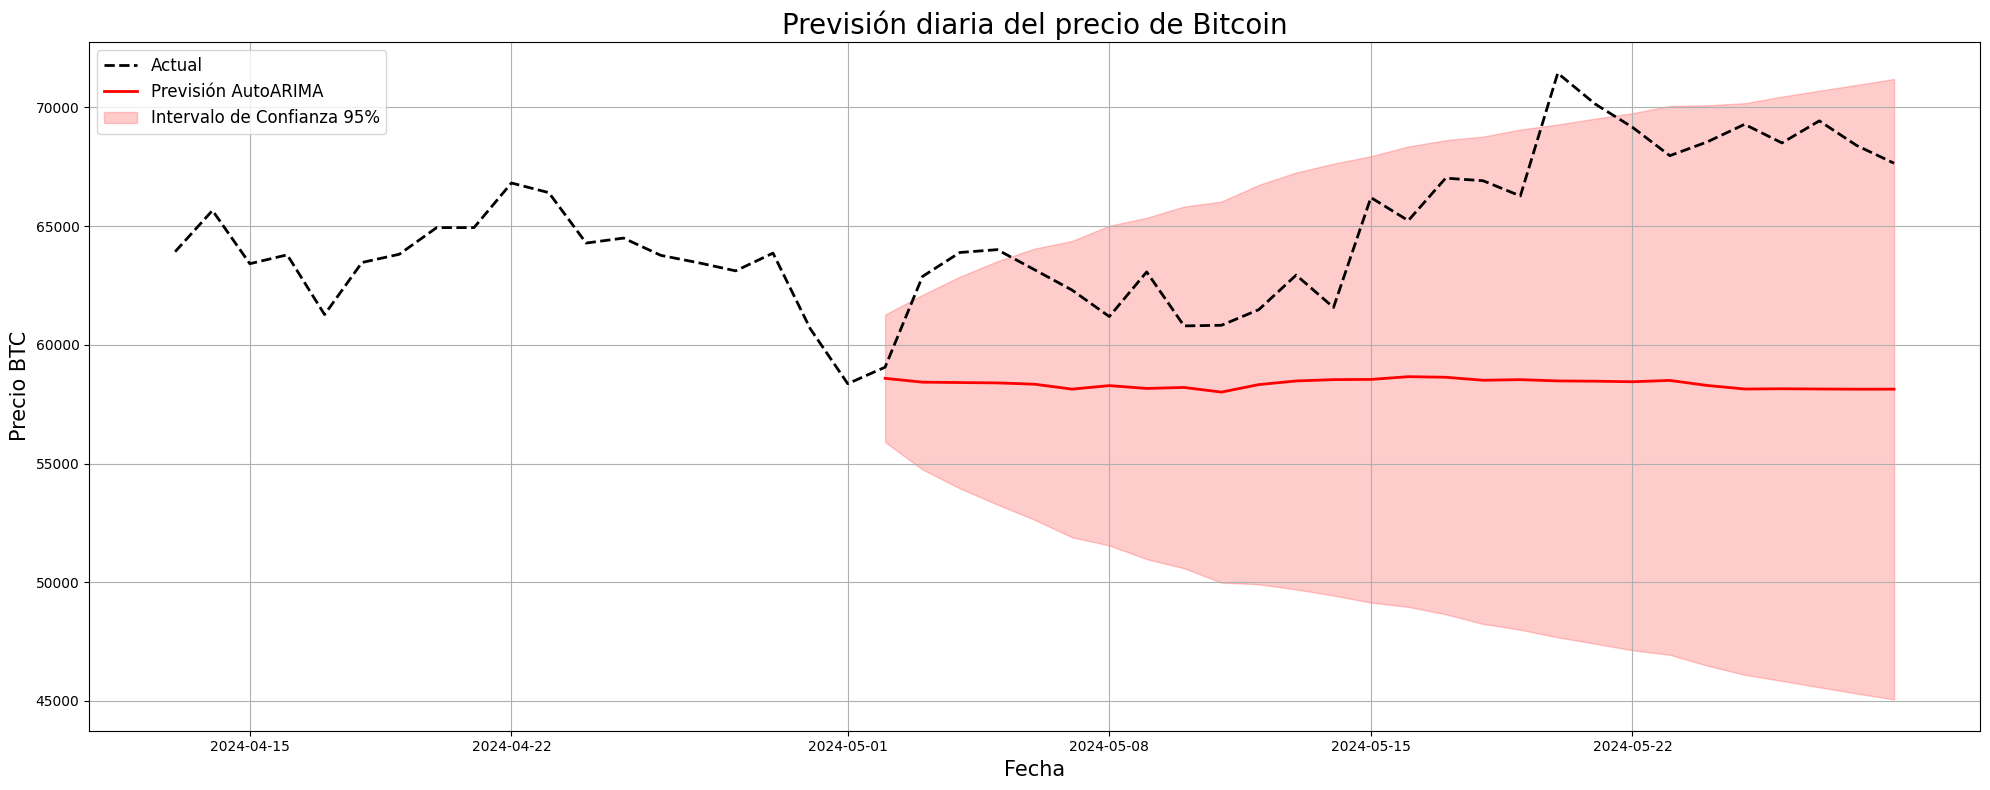

In [99]:
Y_hat_df = sf.forecast(horizon, fitted=True)
print(Y_hat_df.head())

fig, ax = plt.subplots(1, 1, figsize=(20, 8))
plt.plot(df_plot.index, df_plot['y'], 'k--', label="Actual", linewidth=2)
plt.plot(df_plot.index, df_plot['AutoARIMA'], label="Previsión AutoARIMA", linewidth=2, color="red")
ax.fill_between(df_plot.index,
                df_plot['AutoARIMA-lo-95'],
                df_plot['AutoARIMA-hi-95'],
                alpha=.2,
                color='red',
                label='Intervalo de Confianza 95%')

ax.set_title('Previsión diaria del precio de Bitcoin', fontsize=20)
ax.set_ylabel('Precio BTC', fontsize=15)
ax.set_xlabel('Fecha', fontsize=15)
ax.legend(prop={'size': 12})
ax.grid(True)

plt.tight_layout()
plt.show()

In [100]:
print(Y_hat_df.tail())

                  ds     AutoARIMA
unique_id                         
1         2024-05-25  58141.457031
1         2024-05-26  58152.042969
1         2024-05-27  58141.695312
1         2024-05-28  58134.113281
1         2024-05-29  58134.562500


## Métricas de evaluación

In [101]:
# Calcular MAPE y sMAPE manualmente ya que statsmodels no las proporciona directamente
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def symmetric_mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred))) * 100

mape = mean_absolute_percentage_error(y_true, y_pred)
smape = symmetric_mean_absolute_percentage_error(y_true, y_pred)

print(f'MAPE: {mape:.2f}%')
print(f'sMAPE: {smape:.2f}%')

MAPE: 10.44%
sMAPE: 11.14%
